1. Laden Sie die Trainingsdaten.

In [1]:
import pandas as pd

train_df =  pd.read_csv('data/train.csv', delimiter=';')
train_df.head()

,transactionId,basket,customerType,totalAmount,returnLabel
0,9534310106,"[4, 3, 4]",new,252.0,1
1,7202594767,"[4, 2, 0, 2, 5]",existing,70.0,0
2,2737331698,[5],existing,84.0,0
3,4868011733,"[1, 4, 2, 4]",existing,116.0,0
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",existing,378.0,0


2. Führen Sie eine kurze EDA durch (Details auf Folie 13).

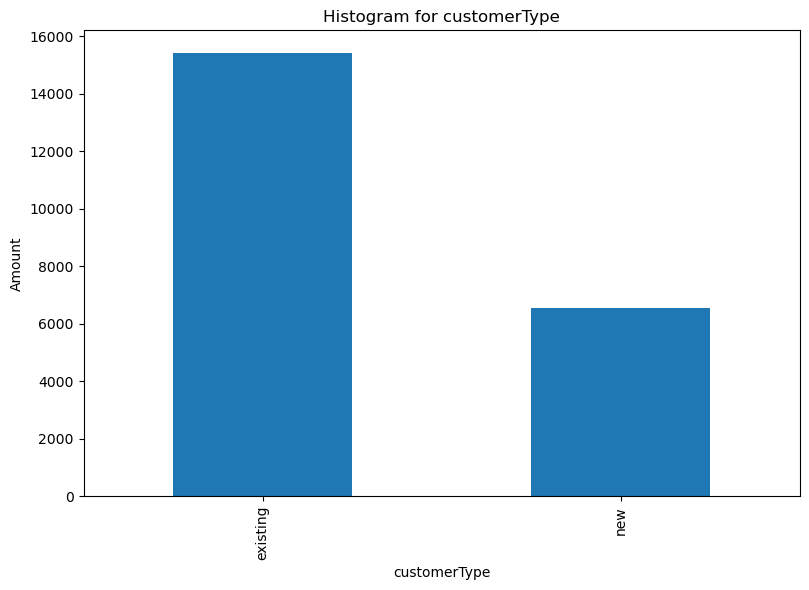

In [2]:
import matplotlib.pyplot as plt

ax = train_df['customerType'].value_counts().plot.bar(figsize=(8, 6), title='Histogram for customerType')
plt.tight_layout()
ax.set_ylabel('Amount')
plt.show()

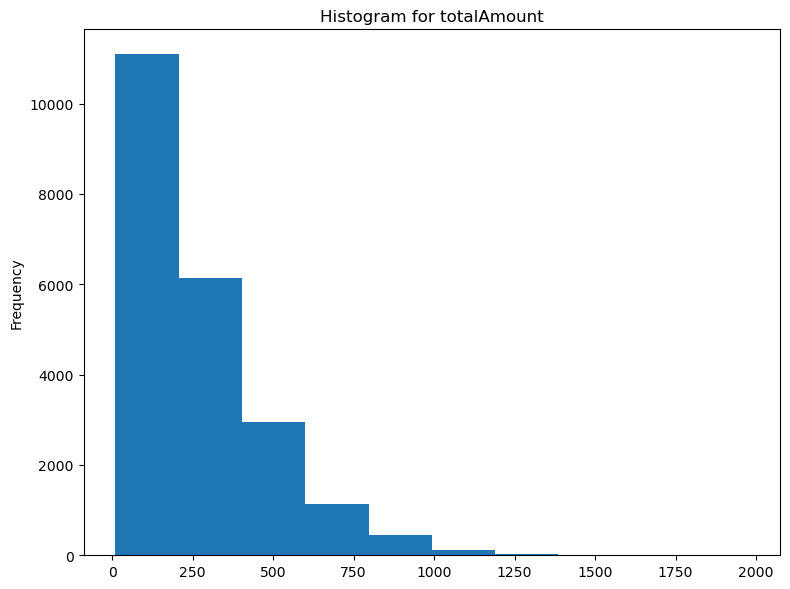

In [3]:
train_df['totalAmount'].plot.hist(bins=10, figsize=(8, 6), title='Histogram for totalAmount')
plt.tight_layout()
plt.show()

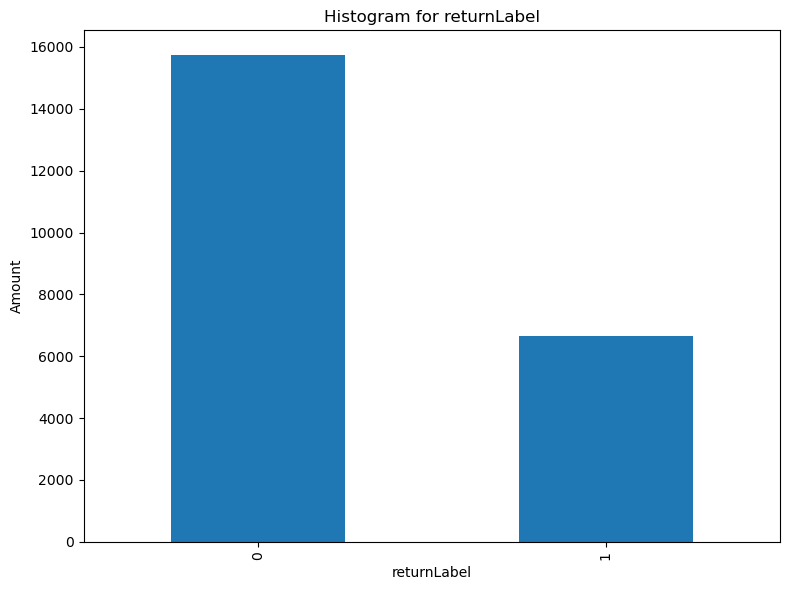

In [4]:
ax = train_df['returnLabel'].value_counts().plot.bar(figsize=(8, 6), title='Histogram for returnLabel')

ax.set_ylabel('Amount')
plt.tight_layout()
plt.show()

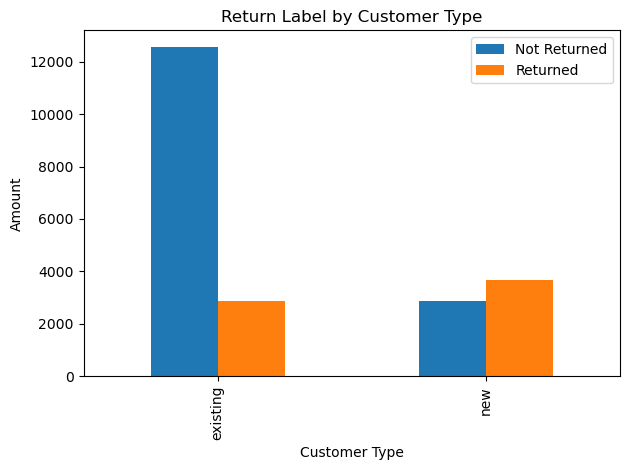

In [5]:
return_by_customer = train_df.groupby(['customerType', 'returnLabel']).size().unstack(fill_value=0)
ax =return_by_customer.plot.bar(title='Return Label by Customer Type')
ax.set_ylabel('Amount')
ax.set_xlabel('Customer Type')
ax.legend(['Not Returned', 'Returned'])

plt.tight_layout()
plt.show()


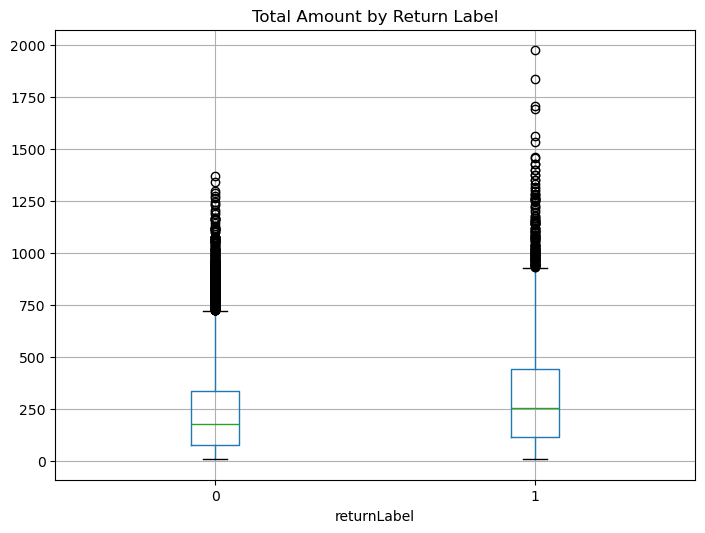

In [6]:
train_df.boxplot(column='totalAmount', by='returnLabel', figsize=(8, 6))
plt.title('Total Amount by Return Label')
plt.suptitle('')
plt.show()


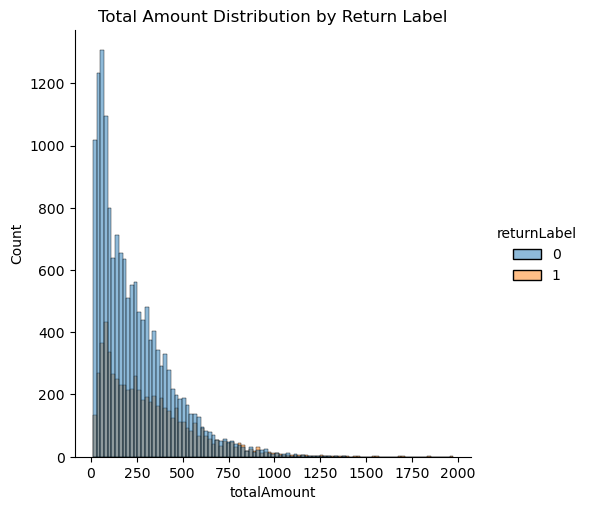

In [7]:
import seaborn as sns
sns.displot(train_df, x='totalAmount', hue='returnLabel', kind='hist')
plt.title('Total Amount Distribution by Return Label')
plt.show()

3. Füllen Sie fehlende Werte in den Trainingsdaten auf.


In [8]:
basket_nan1 = train_df['basket'].isna().sum()
customerType_nan1 = train_df['customerType'].isna().sum()
totalAmount_nan1 = train_df['totalAmount'].isna().sum()
returnLabel_nan1 = train_df['returnLabel'].isna().sum()
nan_values1 = train_df.isna().sum().sum()

print(f'Der Datensatz before filled enthält {nan_values1} NaN-Werte.')
print(f'basket enthält {basket_nan1} NaN-Werte.')
print(f'customerType enthält {customerType_nan1} NaN-Werte.')
print(f'totalAmount enthält {totalAmount_nan1} NaN-Werte.')
print(f'returnLabel enthält {returnLabel_nan1} NaN-Werte.\n')

train_df['totalAmount'] = train_df['totalAmount'].fillna(train_df['totalAmount'].mean())
train_df['customerType'] = train_df['customerType'].fillna(train_df['customerType'].mode()[0])

basket_nan = train_df['basket'].isna().sum()
customerType_nan = train_df['customerType'].isna().sum()
totalAmount_nan = train_df['totalAmount'].isna().sum()
returnLabel_nan = train_df['returnLabel'].isna().sum()
nan_values = train_df.isna().sum().sum()

print(f'Der Datensatz after filled enthält {nan_values} NaN-Werte.')
print(f'basket enthält {basket_nan} NaN-Werte.')
print(f'customerType enthält {customerType_nan} NaN-Werte.')
print(f'totalAmount enthält {totalAmount_nan} NaN-Werte.')
print(f'returnLabel enthält {returnLabel_nan} NaN-Werte.')


Der Datensatz before filled enthält 919 NaN-Werte.
basket enthält 0 NaN-Werte.
customerType enthält 442 NaN-Werte.
totalAmount enthält 477 NaN-Werte.
returnLabel enthält 0 NaN-Werte.

Der Datensatz after filled enthält 0 NaN-Werte.
basket enthält 0 NaN-Werte.
customerType enthält 0 NaN-Werte.
totalAmount enthält 0 NaN-Werte.
returnLabel enthält 0 NaN-Werte.


4. Transformieren Sie die kategorischen Features mittels One-hot-encoding.

In [9]:
oh_train_df = pd.get_dummies(train_df, columns=['customerType', 'returnLabel'])
oh_train_df.head()

,transactionId,basket,totalAmount,customerType_existing,customerType_new,returnLabel_0,returnLabel_1
0,9534310106,"[4, 3, 4]",252.0,False,True,False,True
1,7202594767,"[4, 2, 0, 2, 5]",70.0,True,False,True,False
2,2737331698,[5],84.0,True,False,True,False
3,4868011733,"[1, 4, 2, 4]",116.0,True,False,True,False
4,7622406570,"[2, 5, 3, 2, 3, 2, 0]",378.0,True,False,True,False


5. Versuchen Sie auf Basis des Attributs basket Features zu bauen (z.B. wie oft
kommt jede Kategorie im Basket vor)

In [10]:
def parse_basket(basket_str):
    basket_list = eval(basket_str)
    return basket_list

def create_basket_features(df):
    df = df.copy()
    df['basket_parsed'] = df['basket'].apply(parse_basket)
    
    df['basket_Amount'] = df['basket_parsed'].apply(len)
    
    for i in range(6):
        df[f'category_{i}'] = df['basket_parsed'].apply(lambda x: x.count(i))
    
    return df

train_features = create_basket_features(oh_train_df)

y_train = train_features['returnLabel_1']

feature_columns = ['totalAmount', 'basket_Amount'] + [f'category_{i}' for i in range(6)] + ['customerType_existing', 'customerType_new']

X_train = train_features[feature_columns]

print("Feature matrix shape:", X_train.shape)
print("Features:", X_train.columns.tolist())

Feature matrix shape: (22400, 10)
Features: ['totalAmount', 'basket_Amount', 'category_0', 'category_1', 'category_2', 'category_3', 'category_4', 'category_5', 'customerType_existing', 'customerType_new']


6. Skalieren Sie die Features mit einem StandardScaler.

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

print(X_train_scaled)
print("Feature matrix shape after scaling:", X_train_scaled.shape)

[[-0.03282349 -0.60727524 -0.77156277 ... -0.64410553 -1.55861197
   1.55861197]
 [-0.87945944  0.13320354  0.38348676 ...  0.52709049  0.64159651
  -0.64159651]
 [-0.8143336  -1.34775403 -0.77156277 ...  0.52709049  0.64159651
  -0.64159651]
 ...
 [-0.04677903 -0.60727524  0.38348676 ... -0.64410553 -1.55861197
   1.55861197]
 [-0.83294098  1.24392171  0.38348676 ...  2.86948253  0.64159651
  -0.64159651]
 [ 1.08361952 -0.23703585  0.38348676 ... -0.64410553 -1.55861197
   1.55861197]]
Feature matrix shape after scaling: (22400, 10)


7. Trainieren Sie die folgenden Klassifikationsmodelle und probieren Sie die
angegebenen Hyperparameter mittels Cross-Validation aus:
    1. Logistische Regression: C :[0.1,1,4,5,6,10,30,100] und penalty: ["l1", "l2"]
    2. Random Forest: n_estimators: [60,80,100,120,140] und max_depth: [2, 4, 6]
    3. Gradient Boosting Tree: gleiche Hyperparameter wie bei Random Forest.

8. Laden Sie die Testdaten

9. Entfernen Sie alle Zeilen mit fehlenden Werten

10. Transformieren Sie die Attribute genauso wie bei den Trainingsdaten.

11. Skalieren Sie die Daten im gleichem Maß wie die Trainingsdaten

12. Machen Sie eine Vorhersage auf den Testdaten mit allen drei Modellen und den
jeweils besten Hyperparametern aus der Cross Validation.

13. Berechnen Sie für jedes der drei Modell Accuracy, Precision und Recall.

14. Berechnen Sie außerdem die Accuracy auf den Trainingsdaten und vergleichen Sie
Accuracy auf Trainings- und Testdaten. Liegt Overfitting vor? (Unterschied > 5%)

5. Untersuchen Sie wieviele Datenpunkte es in den Testdaten gibt, welche von allen
drei Modellen falsch klassifiziert wurden:
    1. Bestimmen Sie für jedes der drei Modelle die Indizes der Testdatenpunkte auf
    welchen das jeweilige Modell falsch klassifiziert hat.
    2. Nutzen Sie die set-Klasse in Python um die Anzahl an Datenpunkten zu
    bestimmen, welche von allen drei Modellen falsch klassifiziert wurden.

16. Vergleichen Sie die Feature-Importances der drei Modelle in einem Plot